In [14]:
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
import utils as utils
import pysindy as ps
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz
from scipy.integrate import odeint
import sys
from sklearn import preprocessing
import plot as plot
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings
import datetime

from ns_sfd import constants
from ns_sfd import datautils
from ns_sfd import orbital_state

from common import orbits
import traceback

import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import (
    EncoderNormalizer,
    GroupNormalizer,
    MultiNormalizer,
    NaNLabelEncoder,
    TorchNormalizer,
)
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


datautils.data.set_data_dir("Notebooks/data/orekit-data")
##############################################################
##############################################################
##############################################################

#read data from pickle
full_dataUnpickled = pd.read_pickle("../dataMultipleOrbits.pkl")

# full_dataUnpickled['time_idx'] = range(1, len(full_dataUnpickled) + 1)
full_dataUnpickled.sort_values(
["orbit_id", "time"],
ascending=[True, True],
inplace=True
)
#remove orbit with orbit ids 120 and 136 (wrong orbit generated???)
full_dataUnpickled = full_dataUnpickled[full_dataUnpickled["orbit_id"] != "120"]
full_dataUnpickled = full_dataUnpickled[full_dataUnpickled["orbit_id"] != "136"]

full_dataUnpickled["time_idx"] = full_dataUnpickled.groupby("orbit_id").cumcount()
#divide x,y,z,vx,vy,vz by 1000 to get km and km/s
full_dataUnpickled[["x", "y", "z", "xdot", "ydot", "zdot", "xdotdot", "ydotdot", "zdotdot", "alt"]] = full_dataUnpickled[["x", "y", "z", "xdot", "ydot", "zdot", "xdotdot", "ydotdot", "zdotdot", "alt"]]/1000

full_dataUnpickled['timeAux'] = full_dataUnpickled.groupby('orbit_id')['time'].transform(lambda x: x - x.min())
full_dataUnpickled['timeAux'] = full_dataUnpickled['timeAux'] + 1577836800
full_dataUnpickled['datetime'] = pd.to_datetime(full_dataUnpickled['timeAux'], unit='s')
full_dataUnpickled = full_dataUnpickled.drop(columns=["xdotdot", "ydotdot", "zdotdot", "ecc",  "inc", "alt", "timeAux", "time"], axis =1)

print(full_dataUnpickled.head())
print(full_dataUnpickled.shape)


File or folder: c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\src\Notebooks\data\orekit-data  not found


        The Orekit library relies on some external data for physical models. 
        Typical data are the Earth Orientation Parameters and the leap seconds history, 
        both being provided by the IERS or the planetary ephemerides provided by JPL. 
        Such data is stored in text or binary files with specific formats that Orekit knows 
        how to read, and needs to be provided for the library to work.

        You can download a starting file with this data from the orekit gitlab at:
        https://gitlab.orekit.org/orekit/orekit-data

        or by the function:
        orekit.pyhelpers.download_orekit_data_curdir()

        
                  x           y         z      xdot      ydot          zdot  \
564676  6710.355095    0.000000  0.000000 -0.000000  7.745631  0.000000e+00   
564677  6710.244282   38.727941 -0.000002 -0.044325  7.745502 -6.972456e-07   


In [2]:
 #predict for the next 4 hours
# max_prediction_length 700
# max_encoder_length = 700
max_prediction_length = 200
max_encoder_length = 400
#reduzir tamanho so para testar
full_dataUnpickled = full_dataUnpickled[:50000]

train_pd = full_dataUnpickled.iloc[:-10000]
print(train_pd.shape)

print(full_dataUnpickled.head())

trainingData = TimeSeriesDataSet(
    train_pd,
    target=["x", "y", "z", "xdot", "ydot", "zdot"],
    # target = "x",
    time_idx="time_idx",
    group_ids=["orbit_id"],
    #defines the lookback period
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length= max_encoder_length,
    #specifies how many datapoints will be predicted
    min_prediction_length=1,
    max_prediction_length= max_prediction_length,
    time_varying_known_reals=["time_idx"],
    # time_varying_unknown_reals=["x", "y", "z", "xdot","ydot","zdot","xdotdot","ydotdot","zdotdot", "ecc", "inc", "alt"],
    # static_categoricals=["orbit_id"],
    # target_normalizer = GroupNormalizer(groups=["orbit_id"], transformation="softplus"),
    # target_normalizer=MultiNormalizer([EncoderNormalizer(), TorchNormalizer()]),
    categorical_encoders={
    'orbit_id':NaNLabelEncoder(add_nan=True)
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(trainingData, train_pd.append(full_dataUnpickled.iloc[-10000:-6000]), predict=True, stop_randomization=True)
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = trainingData.to_dataloader(train=True, batch_size=batch_size, num_workers=15)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=15)
#get the data from the dataloader
x, y = next(iter(train_dataloader))
print(np.shape(x))
print(np.shape(y))

(40000, 9)
                  x           y         z      xdot      ydot          zdot  \
564676  6710.355095    0.000000  0.000000 -0.000000  7.745631  0.000000e+00   
564677  6710.244282   38.727941 -0.000002 -0.044325  7.745502 -6.972456e-07   
564678  6709.911847   77.454598 -0.000007 -0.088649  7.745118 -1.398361e-06   
564679  6709.357801  116.178692 -0.000016 -0.132969  7.744477 -2.103379e-06   
564680  6708.582163  154.898944 -0.000028 -0.177285  7.743581 -2.812275e-06   

       orbit_id  time_idx            datetime  
564676        0         0 2020-01-01 00:00:00  
564677        0         1 2020-01-01 00:00:05  
564678        0         2 2020-01-01 00:00:10  
564679        0         3 2020-01-01 00:00:15  
564680        0         4 2020-01-01 00:00:20  
               x         y         z      xdot      ydot      zdot  orbit_id  \
564676  1.332507 -0.028407 -0.107888  0.126957  2.614229 -0.029538         1   
564677  1.332485 -0.014219 -0.107888  0.118462  2.614186 -0.029539

C:\Users\jpfun\AppData\Local\Temp\ipykernel_12776\3239911598.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation = TimeSeriesDataSet.from_dataset(trainingData, train_pd.append(full_dataUnpickled.iloc[-10000:-6000]), predict=True, stop_randomization=True)
c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\pytorch_forecasting\data\encoders.py:317: UserWarning: Found 2 unknown classes which were set to NaN
  warnings.warn(


()
(2,)


c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\numpy\core\fromnumeric.py:1970: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [3]:

##############################
##############################
# Multiple Targets
##############################
##############################

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logsReal")  # logging results to a tensorboard


trainer = pl.Trainer(
    max_epochs=20,
    gpus=0,
    enable_model_summary="top",
    gradient_clip_val= 0.22730,
    # limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    enable_progress_bar=True,
)

tft = TemporalFusionTransformer.from_dataset(
    trainingData,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.1,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=3,
    dropout=0.2,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=6,  # set to <= hidden_size
    # output_size=7,  # 7 quantiles by default
    output_size=[7,7,7,7,7,7],  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)


c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module`

Number of parameters in network: 9.4k
Epoch 19: 100%|██████████| 335/335 [10:51<00:00,  1.95s/it, loss=1.05e+03, v_num=25, train_loss_step=1.12e+3, val_loss=1.41e+3, train_loss_epoch=1.08e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 335/335 [10:51<00:00,  1.95s/it, loss=1.05e+03, v_num=25, train_loss_step=1.12e+3, val_loss=1.41e+3, train_loss_epoch=1.08e+3]


In [4]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

trainer.logged_metrics

{'train_loss_step': tensor(1122.5884),
 'val_loss': tensor(1408.6488),
 'x val_SMAPE': tensor(0.4665),
 'y val_SMAPE': tensor(0.7201),
 'z val_SMAPE': tensor(0.7112),
 'xdot val_SMAPE': tensor(0.4121),
 'ydot val_SMAPE': tensor(1.4092),
 'zdot val_SMAPE': tensor(0.6922),
 'x val_MAE': tensor(1278.5945),
 'y val_MAE': tensor(977.3645),
 'z val_MAE': tensor(490.9911),
 'xdot val_MAE': tensor(0.9275),
 'ydot val_MAE': tensor(2.2052),
 'zdot val_MAE': tensor(0.8460),
 'x val_RMSE': tensor(1498.6586),
 'y val_RMSE': tensor(1617.6245),
 'z val_RMSE': tensor(632.4661),
 'xdot val_RMSE': tensor(1.0527),
 'ydot val_RMSE': tensor(2.9803),
 'zdot val_RMSE': tensor(1.1587),
 'x val_MAPE': tensor(1.0796),
 'y val_MAPE': tensor(5.6871),
 'z val_MAPE': tensor(3.1995),
 'xdot val_MAPE': tensor(0.9462),
 'ydot val_MAPE': tensor(5.9779),
 'zdot val_MAPE': tensor(4.0619),
 'train_loss_epoch': tensor(1081.6328)}

<Figure size 6000x3000 with 0 Axes>

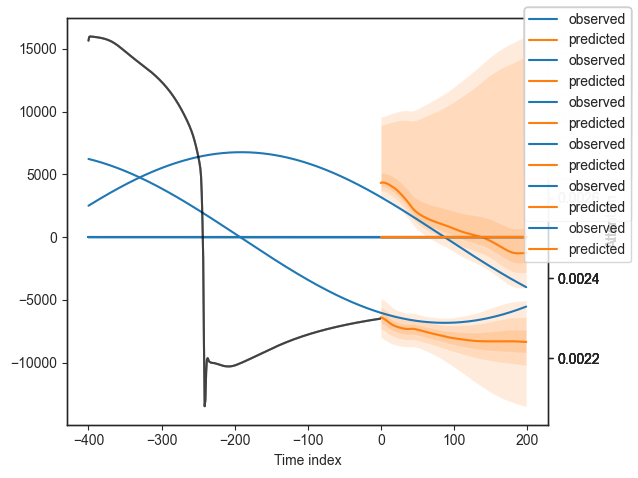

In [5]:
import seaborn as sns
new_raw_predictions, new_x = best_tft.predict(val_dataloader,mode='raw', return_x=True)


sns.set_style('ticks', {'legend.frameon':True})
fig =plt.figure(1,figsize=(10,5),dpi=600)
m =best_tft.plot_prediction(new_x, new_raw_predictions,idx=0, show_future_observed=True,add_loss_to_title=False,);
  #  m.xaxis.set_xticklabels(new_data.time.unique())
    #plt.legend()
   # plt.tight_layout()
    #plt.savefig('plots/predictions_00000'+str(idx)+'.pdf')

In [8]:
encoder_target = torch.stack(new_x['encoder_target']).detach().cpu().numpy()
decoder_target = torch.stack(new_x['decoder_target']).detach().cpu().numpy()
y_all = np.concatenate((encoder_target,decoder_target),axis=2)

#não é preciso estar hardcoded
n_pred = 200 # n de previsoes
n_obs = 400
x_obs = np.arange(-n_obs, 0) 
x_pred = np.arange(n_pred)
prop_cycle = iter(plt.rcParams["axes.prop_cycle"]) #colors, irrelevant
obs_color = next(prop_cycle)["color"]
pred_color = next(prop_cycle)["color"]
plot_attention = True
var_idx = 0  # this identifies the variable being plotted, change at will

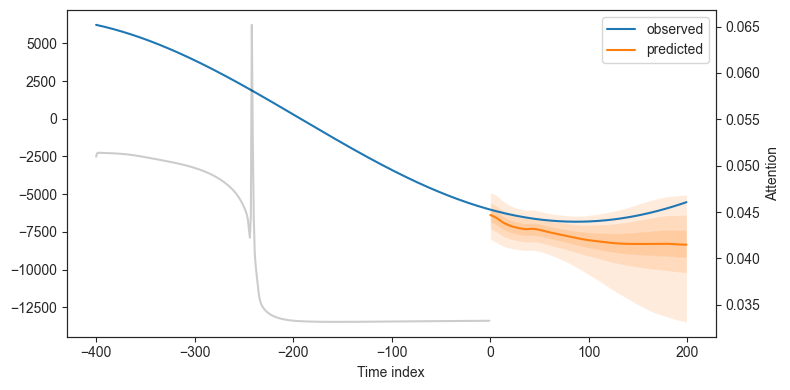

In [9]:
fig=plt.figure(1,figsize=(8,4),dpi=100)
ax = plt.gca()

y_raw = new_raw_predictions.prediction[var_idx].detach().cpu().numpy()
y_quantile_number = np.shape(y_raw)[2]
ax.plot(x_obs, y_all[var_idx][0][:n_obs], label="observed", c=obs_color)
ax.plot(x_pred, y_all[var_idx][0][-n_pred:], c=obs_color)
ax.plot(x_pred,y_raw[0,:,y_quantile_number // 2],label='predicted',c=pred_color)
for i in range(y_quantile_number // 2):
                if len(x_pred) > 1:
                    ax.fill_between(x_pred, y_raw[0,:, i], y_raw[0,:, -i - 1], alpha=0.15, fc=pred_color)
                
if plot_attention:
            interpretation = best_tft.interpret_output(new_raw_predictions, reduction="sum")
            ax2 = ax.twinx()
            ax2.set_ylabel("Attention")
            encoder_length = x["encoder_lengths"][0]
            ax2.plot(
                np.arange(-n_obs, 0),
                interpretation["attention"].detach().cpu(),
                alpha=0.2,
                color="k",
            )             
                
ax.set_xlabel("Time index")
ax.legend()
fig.tight_layout()
plt.show()

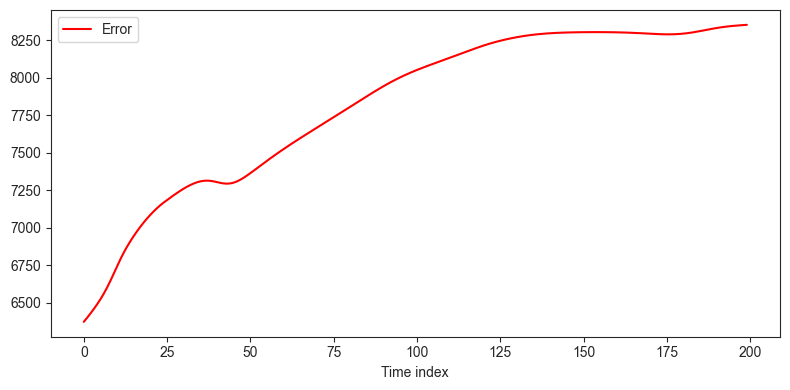

In [11]:
#graph comparing the difference between the observed data and the predicted

var_idx = 0  # this identifies the variable being plotted, change at will
fig=plt.figure(1,figsize=(8,4),dpi=100)
ax = plt.gca()
# ax.plot(x_obs, y_all[var_idx][0][:n_obs], label="observed", c=obs_color)
# ax.plot(x_pred, y_all[var_idx][0][-n_pred:], c=obs_color)
# ax.plot(x_pred,y_raw[0,:,y_quantile_number // 2],label='predicted',c=pred_color)
ax.plot(x_pred,y_all[var_idx][0][-n_pred:]-y_raw[0,:,y_quantile_number // 2],label='Error',c='r')
ax.set_xlabel("Time index")
ax.legend()
fig.tight_layout()
plt.show()
